In [1]:
%env CUDA_VISIBLE_DEVICES=7

import jax
from jax import nn
from jax import numpy as jnp
from jax import random as jr
from util import *
import optax
from flax.traverse_util import flatten_dict, unflatten_dict

import pickle
import argparse

env: CUDA_VISIBLE_DEVICES=7


/data/eshaan/anaconda3/envs/jax/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/data/eshaan/anaconda3/envs/jax/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [ ]:
class linear(nn.Module):
    d: int
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.d, use_bias = False, name = 'layer1')(x)
        return z
    
def run(d, N, lr, probs, rng):
    
    lr = lr
    wd = 0.
    steps = 2**12
    save_every = steps // 128
    
    U = jr.normal(rng.next(), (N, d))
    U = vmap(lambda u: u/jnp.linalg.norm(u))(U)
    E = jr.normal(rng.next(), (N, d))
    E = vmap(lambda u: u/jnp.linalg.norm(u))(E)
    
    model = linear(d = d)

    p0 = model.init(rng.next(), E)
    p0 = flatten_dict(p0["params"], sep=".")
    
    
    @partial(jit, static_argnames="mutable")
    def f(p, *args, **kwargs):
        p = dict(params=unflatten_dict(p, sep="."))
        return model.apply(p, *args, **kwargs)
    @jit
    def criterion(i, y_hat):
        return -jnp.log(y_hat[i])

    @jit
    def loss_fn(p):
        preds = nn.softmax(f(p, E) @ U.T)
        return vmap(criterion)(jnp.arange(N), preds) @ probs

    @jit
    def accuracy(p):
        preds = f(p, E) @ U.T
        return vmap(lambda yi, fi: jnp.argmax(fi) == yi)(jnp.arange(N), preds) @ probs
    
    @jit
    def linear_AM_acc():
        preds = E @ E.T @ U @ U.T
        return vmap(lambda yi, fi: jnp.argmax(fi) == yi)(jnp.arange(N), preds) @ probs
    
    def custom_schedule(step):
        return jnp.where(step < 2**12, lr, lr/10.)

    # schedule = optax.Schedule(custom_schedule)
    
    # Init optimizer
    opt = optax.adamw(learning_rate = lr, weight_decay=wd)
    # opt = optax.sgd(learning_rate = lr, momentum = 0.9)

    @jit
    def step_fn_adam(p, opt_state):
        loss, g = jax.value_and_grad(loss_fn)(p)
        updates, opt_state = opt.update(g, opt_state, p)
        p = optax.apply_updates(p, updates)
        return p, opt_state, loss
    
    p = p0
    losses = []
    accs = []
    
    opt_state = opt.init(p0)
    for i in trange(steps):
        p, opt_state, loss = step_fn_adam(p, opt_state)
        losses.append(loss)
        if i % save_every == 0:
            acc = accuracy(p)
            accs.append(acc)
            if acc > 0.99:
                break

    acc = max(accs)
    loss = min(losses)
    # AM_acc = linear_AM_acc()
    AM_acc = None
    print(acc, AM_acc, loss)
    return acc, losses, loss

In [3]:
def binary_sweep(d, min_N, max_N, lrs, rng):
    
    max_size = max_N
    min_size = min_N
    threshhold = 0.99
    while (max_size/min_size > 1.01) and (max_size - min_size > 1):
        N = int(0.5*(max_size + min_size))
        
        for lr in lrs:
            acc, _, loss = run(d, N, lr, jnp.ones(N)/N, rng)
            print(N, lr, acc)
            if acc >= threshhold:
                min_size = N
                break
        if acc < threshhold:
            max_size = N
            
    return min_size

In [ ]:
d_range = [int(2**i) for i in jnp.arange(3, 5, 0.5)]
seeds = [0, 1, 11, 111, 42]
all_Ns = []
for seed in seeds:
    print("################## SEED = {} ###############".format(seed))
    Ns = []
    for d in d_range:
        N = binary_sweep(d, d, int(0.5*d*d), [1000.], RNG(seed))
        print(N)
        Ns.append(N)
    all_Ns.append(Ns)
    
all_Ns = np.array(all_Ns)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman


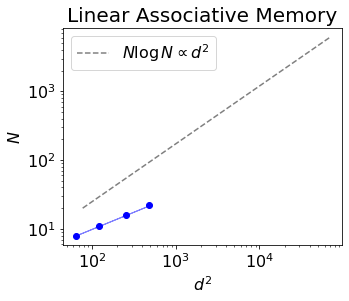

In [ ]:
plt.style.use('style.mplstyle')
fig, ax = plt.subplots(figsize = (5, 4))
d_range = [int(2**i) for i in jnp.arange(3, 5, 0.5)]

plt.scatter([d**2 for d in d_range], all_Ns.mean(axis=0), marker = 'o', color = 'b')
plt.fill_between([d**2 for d in d_range], all_Ns.min(axis=0), all_Ns.max(axis=0), color = 'b', alpha = 0.5)

N_ends = [20, 6000]
C = 1.3
plt.plot([C*N_ends[0]*jnp.log(N_ends[0]), C*N_ends[1]*jnp.log(N_ends[1])], N_ends, linestyle = 'dashed', color = 'gray', label=r'$N\log N \propto d^2$')

plt.yscale("log")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r'$d^2$')
plt.ylabel(r'$N$')
plt.title("Linear Associative Memory")
plt.legend()
plt.savefig("AM_rescale.pdf", bbox_inches='tight')
plt.show()